<h1 style="text-align:center; color:#daa520">Clustering</h1>

## 1. Data Preparation

In [79]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [80]:
# Create data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

### Load the datasets

In [81]:
try:
    customers_df = pd.read_csv('data/Customers.csv')
    transactions_df = pd.read_csv('data/Transactions.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: Ensure that the CSV files are in the 'data' folder.")
    exit()

Data loaded successfully!


### Convert data columns to datetime objects

In [82]:
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

### Merge transactions with customers

In [83]:
transactions_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')

In [84]:
print("Merged Dataframe Head:")
transactions_df.head()

Merged Dataframe Head:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


## 2. Feature Engineering

### One-hot encode customer region

In [85]:
transactions_df = pd.get_dummies(transactions_df, columns=['Region'], prefix='Region')

### Aggregate total transaction value for each customer

In [86]:
customer_total_value = transactions_df.groupby('CustomerID')['TotalValue'].sum().reset_index()

### Calculate average transaction value for each customer

In [87]:
customer_avg_value = transactions_df.groupby('CustomerID')['TotalValue'].mean().reset_index()
customer_avg_value.rename(columns={'TotalValue': 'AvgValue'}, inplace=True)

### Calculate days since signup

In [88]:
today = pd.to_datetime('today')
customers_df['DaysSinceSignup'] = (today - customers_df['SignupDate']).dt.days

### Merge features into a single dataframe

In [89]:
customer_features = pd.merge(customers_df[['CustomerID', 'DaysSinceSignup']], customer_total_value, on='CustomerID', how='left')
customer_features = pd.merge(customer_features, customer_avg_value, on='CustomerID', how='left')
customer_features = customer_features.fillna(0)


print("\nCustomer Features Head:")
customer_features.head()


Customer Features Head:


,CustomerID,DaysSinceSignup,TotalValue,AvgValue
0,C0001,930,3354.52,670.904
1,C0002,1077,1862.74,465.685
2,C0003,324,2725.38,681.345
3,C0004,839,5354.88,669.360
4,C0005,894,2034.24,678.080


### Aggregate transaction counts for each customer

In [90]:
customer_transaction_counts = transactions_df.groupby('CustomerID').size().reset_index(name='TransactionCount')
customer_features = pd.merge(customer_features, customer_transaction_counts, on='CustomerID', how='left')
customer_features = customer_features.fillna(0)

## 3. Feature Scaling

In [91]:
numerical_features = ['DaysSinceSignup', 'TotalValue', 'AvgValue', 'TransactionCount']
scaler = StandardScaler()
customer_features[numerical_features] = scaler.fit_transform(customer_features[numerical_features])

print("\nScaled Customer Features Head:")
print(customer_features.head())


Scaled Customer Features Head:
  CustomerID  DaysSinceSignup  TotalValue  AvgValue  TransactionCount
0      C0001         1.152884   -0.051884 -0.054781          0.000000
1      C0002         1.605593   -0.862714 -0.903985         -0.451294
2      C0003        -0.713387   -0.393842 -0.011575         -0.451294
3      C0004         0.872636    1.035375 -0.061170          1.353881
4      C0005         1.042017   -0.769499 -0.025086         -0.902587


## 4. Clustering with KMeans

In [92]:
# Clustering with KMeans
db_scores = []
cluster_range = range(2, 11)
customer_ids = customer_features['CustomerID']
customer_features = customer_features.drop('CustomerID', axis=1)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(customer_features)
    db_score = davies_bouldin_score(customer_features, cluster_labels)
    db_scores.append(db_score)
    print(f"Davies-Bouldin score for {n_clusters} clusters: {db_score}")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin score for 2 clusters: 1.345669979358422


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin score for 3 clusters: 1.2695898336150166


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin score for 4 clusters: 1.2158837326542722


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin score for 5 clusters: 1.0494197482361707


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin score for 6 clusters: 1.0831342889892372


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin score for 7 clusters: 0.9792449470397351


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin score for 8 clusters: 0.9533703528805756


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin score for 9 clusters: 1.0028694980000907


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin score for 10 clusters: 0.9953284483833486


### Find the optimal number of clusters

In [93]:
optimal_clusters = cluster_range[np.argmin(db_scores)]
print(f"\nOptimal number of clusters: {optimal_clusters}")


Optimal number of clusters: 8


### Apply KMeans with the optimal number of clusters

In [94]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(customer_features)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Add cluster labels to the customer features dataframe

In [95]:
customer_features['Cluster'] = cluster_labels
customer_features['CustomerID'] = customer_ids

print("\nCustomer Features with Cluster Labels Head:")
customer_features.head()


Customer Features with Cluster Labels Head:


,DaysSinceSignup,TotalValue,AvgValue,TransactionCount,Cluster,CustomerID
0,1.152884,-0.051884,-0.054781,0.000000,0,C0001
1,1.605593,-0.862714,-0.903985,-0.451294,0,C0002
2,-0.713387,-0.393842,-0.011575,-0.451294,4,C0003
3,0.872636,1.035375,-0.061170,1.353881,5,C0004
4,1.042017,-0.769499,-0.025086,-0.902587,0,C0005


## 5. Visualize Clusters

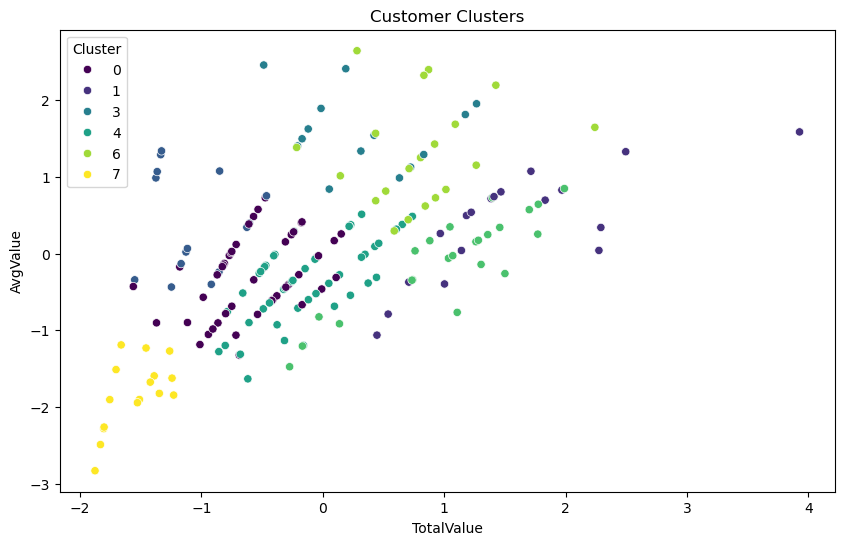

In [96]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='TotalValue', y='AvgValue', hue='Cluster', palette='viridis')
plt.title('Customer Clusters')
plt.show()